# Infinite Message Model: Solution

James Yu, 14 June 2022

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.optimize

There are two equations required to formulate a solution to the infinite message model. The first is the expression for the shadow price $\mu$, which is the budget constraint with $\tilde{\mathbf{y}}_0$ substituted for $\tilde{\mathbf{x}}_0$ via the FOC for $\tilde{\mathbf{y}}_0$ using the solution guess $\tilde{\mathbf{y}}_t = D_k^t \tilde{\mathbf{y}}_0$:

$$\tilde{\mathbf{x}}_0^\prime (\mu (I + \mu I + \mu \delta D^2 - \mu \delta D D_k)^{-1} - I)^2 \tilde{\mathbf{x}}_0 + \delta \tilde{\mathbf{x}}_0^\prime \mu^2 (I + \mu I + \mu \delta D^2  - \mu \delta D D_k)^{-2} (D_k - D)^2 (I - \delta D_k^2)^{-1} \tilde{\mathbf{x}}_0 = C$$

The second is the solution to the second-order difference equation. The solutions $r_k$ are given by:

$$r_k = \frac{\lambda_k^2 + \mu + \mu \delta \lambda_k^2 \pm \sqrt{(\lambda_k^2 + \mu + \mu \delta \lambda_k^2)^2 - 4 \delta \mu^2 \lambda_k^2}}{2\delta\mu \lambda_k}$$

Note that $D_k$ is the diagonal matrix of each $r_k$ so both equations are dependent on $r_k$ and $\mu$. It would be extremely difficult to solve for $\mu$ analytically due to this fact on top of the fact that the budget constraint is already an implicit definition of $\mu$. We can instead use a numerical solution by searching for the $\mu$ that satisfies the equation.

In [2]:
def r_k(lambda_k, mu, delta):
    q_B = (lambda_k ** 2) + mu + (mu * delta * (lambda_k ** 2))
    q_A = delta * mu * lambda_k
    q_C = mu * lambda_k
    if lambda_k > 0:
        root = (q_A - math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # negative sign
        #if np.abs(root) > 1:
        #    print("WARNING: non-convergent root for lambda_k =", lambda_k, "mu =", mu, "delta =", delta)
        return root
    elif lambda_k < 0:
        root = (q_A + math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # positive sign
        #if np.abs(root) > 1:
        #    print("WARNING: non-convergent root for lambda_k =", lambda_k, "mu =", mu, "delta =", delta)
        return root
    else:
        raise Exception("unhandled lambda_k = 0 case found")

In [3]:
r_k(1, 1, 1)

-0.6180339887498949

In [4]:
r_k(-0.5, 1, 0.9)

-0.7549285553418353

Some quick checks:

In [5]:
def r_k_always_negative(lambda_k, mu, delta):
    q_B = (lambda_k ** 2) + mu + (mu * delta * (lambda_k ** 2))
    q_A = delta * mu * lambda_k
    q_C = mu * lambda_k
    return (q_A - math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # negative sign

print(r_k_always_negative(1, 1, 1))
print(r_k_always_negative(-0.5, 1, 0.9))

-0.6180339887498949
1.7549285553418352


Negative eigenvalue with the positive root is non-convergent. 

In [6]:
def r_k_always_positive(lambda_k, mu, delta):
    q_B = (lambda_k ** 2) + mu + (mu * delta * (lambda_k ** 2))
    q_A = delta * mu * lambda_k
    q_C = mu * lambda_k
    return (q_A + math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # negative sign

print(r_k_always_positive(1, 1, 1))
print(r_k_always_positive(-0.5, 1, 0.9))

1.618033988749895
-0.7549285553418353


Converse scenario is true as well. So we have to be careful.

In [7]:
def y0_matrix(mu, delta, D, D_k, n):
    I = np.identity(n)
    return I + (mu * I) + (mu * delta * (D @ D)) - (mu * delta * (D @ D_k))

In [8]:
def budget_constraint(C, tilde_x_0, mu, D, D_k, delta, n):
    I = np.identity(n)
    y0_mat = y0_matrix(mu, delta, D, D_k, n)
    t_0_term = tilde_x_0.T @ np.linalg.matrix_power(((mu * np.linalg.inv(y0_mat)) - I), 2) @ tilde_x_0
    t_sum_term = delta * (mu ** 2) * tilde_x_0.T @ np.linalg.matrix_power(np.linalg.inv(y0_mat), 2) @ (D_k - D) @ (D_k - D) @ np.linalg.inv(I - (delta * (D_k @ D_k))) @ tilde_x_0
    return C - t_0_term - t_sum_term # given the correct mu, this should be zero

Next, we need to formulate a specific network to solve. For example:

In [9]:
x_0 = np.array([[4.0, 10.0, -3.0]], ndmin = 2).T
x_0

array([[ 4.],
       [10.],
       [-3.]])

$A$ must be symmetric in order to perform the eigendecomposition:

In [10]:
A = np.array([
    [0.6, 0.2, 0.2],
    [0.2, 0.3, 0.5],
    [0.2, 0.5, 0.3]
])
A

array([[0.6, 0.2, 0.2],
       [0.2, 0.3, 0.5],
       [0.2, 0.5, 0.3]])

In [11]:
eigvals, U = np.linalg.eig(A)
D = np.diag(eigvals)
np.allclose(U @ D @ U.T, A)

True

This means we have the proper decomposition, since $U D U^\prime$ returns $A$:

In [12]:
U @ D @ U.T

array([[0.6, 0.2, 0.2],
       [0.2, 0.3, 0.5],
       [0.2, 0.5, 0.3]])

We also need a function to compose $D_k$ from each $r_k$:

In [13]:
def D_k_(mu, delta, eigenvalues):
    return np.diag([r_k(lambda_k, mu, delta) for lambda_k in eigenvalues])

In [14]:
D_k_(1, 1, eigvals)

array([[-0.81244047,  0.        ,  0.        ],
       [ 0.        , -0.61803399,  0.        ],
       [ 0.        ,  0.        , -2.00798724]])

This allows us to create the following:

In [15]:
def objective_function(mu_vec, A_, C, x_0_, delta, use_vec = False, suppress_print = False):
    if not suppress_print:
        print("testing", mu_vec)
    if use_vec:
        mu = mu_vec[0]
    else:
        mu = mu_vec
    if mu <= 0:
        # do not allow negative
        return -1 * np.inf
    n = np.size(x_0_)
    eigvals, U = np.linalg.eig(A_)
    D = np.diag(eigvals)
    tilde_x_0 = U.T @ x_0_
    D_k = D_k_(mu, delta, eigvals)
    return budget_constraint(C, tilde_x_0, mu, D, D_k, delta, n).item()

This is an expression for the budget constraint solely in terms of $x_0$, $A$, $C$, $\delta$ and a candidate $\mu$.

In [16]:
C = 10
delta = 1

In [17]:
objective_function(1, A, C, x_0, delta)

testing 1


-3.2393960719296473

So now, given the fixed network parameters, we can find the $\mu$ which sets this function to zero. Here are two example solvers from the SciPy library that can do this:

In [18]:
res = scipy.optimize.fsolve(lambda mu: objective_function(mu, A, C, x_0, delta, use_vec = True), 1)

testing [1]
testing [1.]
testing [1.]
testing [1.00000001]
testing [1.03632186]
testing [1.03738804]
testing [1.03741921]
testing [1.03741924]
testing [1.03741924]


In [19]:
res2 = scipy.optimize.brentq(lambda mu: objective_function(mu, A, C, x_0, delta), 0.00000001, 5000)

testing 1e-08
testing 5000.0
testing 1876.5267244409438
testing 705.0238729869541
testing 265.47787205990625
testing 100.46549529806167
testing 38.460160379593226
testing 15.127750795133949
testing 6.329847579122687
testing 3.0041921398534948
testing 1.7456945034634987
testing 0.7787166919044382
testing 1.1784301504322023
testing 1.0722564908966463
testing 1.037514476439488
testing 1.0374193352246752
testing 1.0374192350923614
testing 1.037419235091361


In [20]:
res.item()

1.037419235092048

In [21]:
res2

1.0374192350923614

With respect to rounding error, they yield the same result. Thus, this is a $\mu$ which satisfies the equation. We can validate:

In [22]:
objective_function(res.item(), A, C, x_0, delta)

testing 1.037419235092048


7.105427357601002e-15

With respect to rounding error, this is zero. So it satisfies the budget constraint. We can now use it to retrive the roots:

In [23]:
[r_k(lambda_k, res.item(), delta) for lambda_k in eigvals]

[-0.803359560426444, -0.5937188588580063, -2.0041037235425723]

### Note:

One of those roots has absolute value greater than 1. This means it does not converge, which is a problem.

One of the next questions is whether $\mu$ changes with $C$ the way we expect it to. We can check:

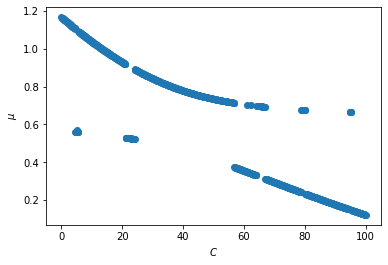

In [24]:
results = []
for C_ in np.linspace(0.000001, 100, 1000):
    results.append(scipy.optimize.brentq(lambda mu: objective_function(mu, A, C_, x_0, delta, suppress_print = True), 0.00000001, 5000))
    
plt.scatter(np.linspace(0.000001, 100, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.show()

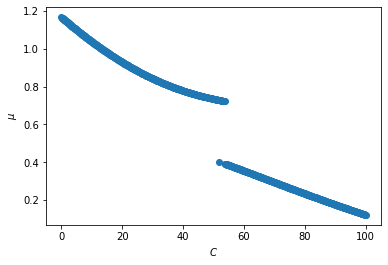

In [25]:
results = []
for C_ in np.linspace(0.000001, 100, 1000):
    results.append(scipy.optimize.fsolve(lambda mu: objective_function(mu, A, C_, x_0, delta, use_vec = True, suppress_print = True), 1))
    
plt.scatter(np.linspace(0.000001, 100, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.show()